In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import os

In [2]:
# Read the CSV File
file_path = r'I:\Desktop\5.2\finaldata.csv'  # Prefix with 'r'
data = pd.read_csv(file_path)


In [3]:

# Define the correct file paths
input_file_path = r'I:\Desktop\5.2\finaldata.csv'
output_file_path = r'I:\Desktop\5.2\labeleddata4_data_file.csv'

# Function to classify temperature
def classify_temperature(temp):
    if temp < 20:
        return 'Low'
    elif temp > 30:
        return 'High'
    else:
        return 'Normal'

# Calculate the magnitude of activity from acceleration data
def calculate_activity_magnitude(row):
    return np.sqrt(row['AcclX']**2 + row['AcclY']**2 + row['AcclZ']**2)

# Define thresholds for activity
def categorize_activity(activity_magnitude):
    if activity_magnitude < 7:
        return 'Low'
    elif activity_magnitude > 10:
        return 'High'
    else:
        return 'Normal'

# Simplified function to label health status with default state as "Sick (Attention Required)"
def label_health_status(row):
    temp_status = classify_temperature(row['Temperature'])
    activity_magnitude = calculate_activity_magnitude(row)
    activity_status = categorize_activity(activity_magnitude)
    
    if temp_status == 'Normal' and activity_status in ['Low','Normal','High']:
        return 'Healthy Cow'
    else:
        return 'Sick (Attention Required)'

# Check if the input file exists
if os.path.isfile(input_file_path):
    try:
        # Load the CSV file into a DataFrame
        df = pd.read_csv(input_file_path)
        
        # Apply the functions to classify and label
        df['TemperatureStatus'] = df['Temperature'].apply(classify_temperature)
        df['ActivityMagnitude'] = df.apply(calculate_activity_magnitude, axis=1)
        df['ActivityStatus'] = df['ActivityMagnitude'].apply(categorize_activity)
        df['HealthStatus'] = df.apply(label_health_status, axis=1)
        
        # Save the updated DataFrame to a new CSV file
        df.to_csv(output_file_path, index=False)
        
        # Verify if the file was created
        if os.path.isfile(output_file_path):
            print(f"File successfully saved to: {output_file_path}")
        else:
            print(f"File not found at the expected path: {output_file_path}")
        
    except pd.errors.EmptyDataError:
        print("The file is empty.")
    except pd.errors.ParserError:
        print("Error parsing the file. It may not be a valid CSV.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
else:
    print(f"Input file not found at the path: {input_file_path}")


File successfully saved to: I:\Desktop\5.2\labeleddata4_data_file.csv


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the dataset (update with the path to your CSV file)
file_path =  r'I:\Desktop\5.2\labeleddata4_data_file.csv'

data = pd.read_csv(file_path)

# Convert categorical columns to numerical using Label Encoding
le = LabelEncoder()

# Encode the 'TemperatureStatus', 'ActivityStatus', and 'HealthStatus' columns
data['TemperatureStatus'] = le.fit_transform(data['TemperatureStatus'])
data['ActivityStatus'] = le.fit_transform(data['ActivityStatus'])
data['HealthStatus'] = le.fit_transform(data['HealthStatus'])  # Target variable

# Select features (input variables) and the target variable
X = data[['AcclX', 'AcclY', 'AcclZ', 'Temperature', 'TemperatureStatus', 'ActivityMagnitude', 'ActivityStatus']]
y = data['HealthStatus']

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Output the shapes of training and testing data
print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}, Test labels shape: {y_test.shape}")


Training data shape: (549, 7), Test data shape: (138, 7)
Training labels shape: (549,), Test labels shape: (138,)


In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import joblib
from micromlgen import port

# Assuming X and y are already defined and preprocessed appropriately
# Here, X contains features: AcclX, AcclY, AcclZ, Temperature, TemperatureStatus, ActivityMagnitude, ActivityStatus
# y contains the target variable, e.g., [0, 1] for 'Healthy' and 'Sick'

# Define preprocessor to scale numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['AcclX', 'AcclY', 'AcclZ', 'Temperature', 'TemperatureStatus', 'ActivityMagnitude', 'ActivityStatus']),
        # No categorical features in this case, so we don't need OneHotEncoder
    ])

# Create a pipeline that preprocesses the data and then applies the Random Forest model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=100))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Define the positive label for binary classification
positive_label = 1  # Use the numeric label instead of 'Sick (Attention Required)'

# Evaluate the model's performance on the test data
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=positive_label)
recall = recall_score(y_test, y_pred, pos_label=positive_label)
f1 = f1_score(y_test, y_pred, pos_label=positive_label)

# Print the results
print("Test Data Performance:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Define custom scorers with the appropriate positive label
precision_scorer = make_scorer(precision_score, pos_label=positive_label)
recall_scorer = make_scorer(recall_score, pos_label=positive_label)
f1_scorer = make_scorer(f1_score, pos_label=positive_label)

# Perform cross-validation with 5 folds
cv_accuracy = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
cv_precision = cross_val_score(pipeline, X, y, cv=5, scoring=precision_scorer)
cv_recall = cross_val_score(pipeline, X, y, cv=5, scoring=recall_scorer)
cv_f1 = cross_val_score(pipeline, X, y, cv=5, scoring=f1_scorer)

# Print the average cross-validation results
print("\nCross-Validation Performance:")
print(f"Cross-Validation Accuracy: {cv_accuracy.mean() * 100:.2f}%")
print(f"Cross-Validation Precision: {cv_precision.mean():.2f}")
print(f"Cross-Validation Recall: {cv_recall.mean():.2f}")
print(f"Cross-Validation F1-Score: {cv_f1.mean():.2f}")

# After training the RandomForest model, save the model
# Save the model as a pickle file
joblib.dump(pipeline, 'random_forest_model.pkl')

# Convert the model to C code using micromlgen for deployment on ESP32
c_code = port(pipeline.named_steps['classifier'])

# Print the C code to use in your ESP32 firmware
print("\nGenerated C Code for ESP32 Deployment:")
print(c_code)

# Optionally, save the C code to a file
with open('random_forest_model2_for_ESP32.c', 'w') as f:
    f.write(c_code)


Test Data Performance:
Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1-Score: 1.00

Cross-Validation Performance:
Cross-Validation Accuracy: 99.71%
Cross-Validation Precision: 0.99
Cross-Validation Recall: 1.00
Cross-Validation F1-Score: 1.00

Generated C Code for ESP32 Deployment:
#pragma once
#include <cstdarg>
namespace Eloquent {
    namespace ML {
        namespace Port {
            class RandomForest {
                public:
                    /**
                    * Predict class for features vector
                    */
                    int predict(float *x) {
                        uint8_t votes[2] = { 0 };
                        // tree #1
                        if (x[4] <= -0.32778114080429077) {
                            votes[1] += 1;
                        }

                        else {
                            votes[0] += 1;
                        }

                        // tree #2
                        if (x[4] <= -0.32778114080429077) {
   

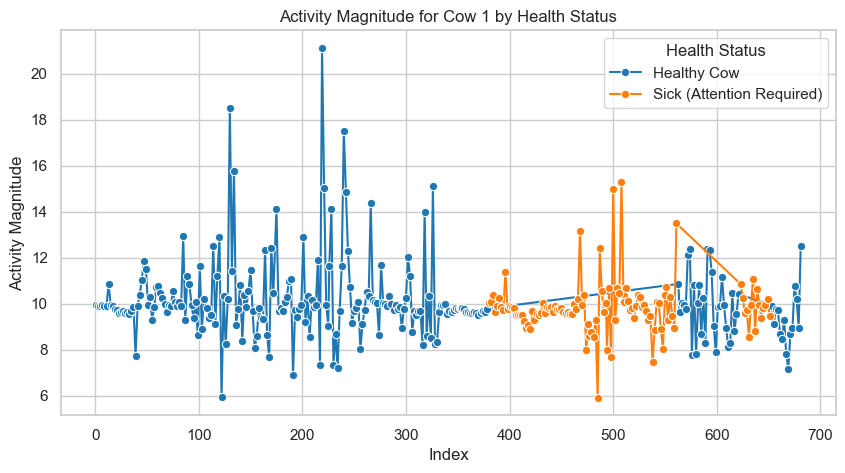

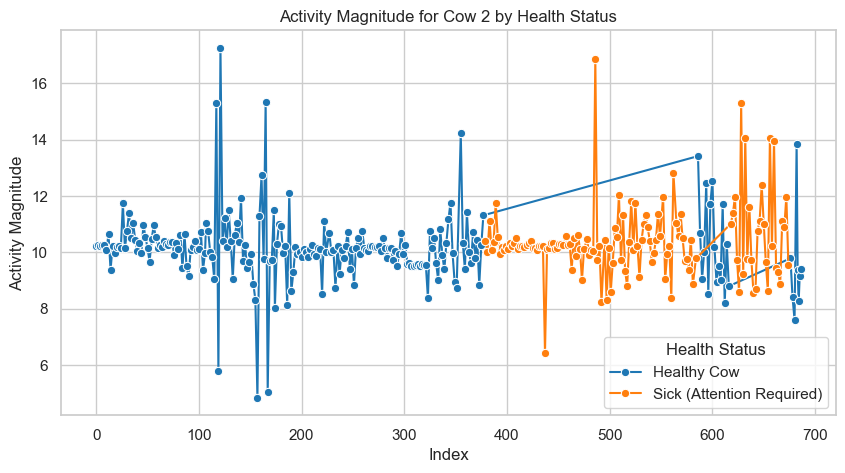

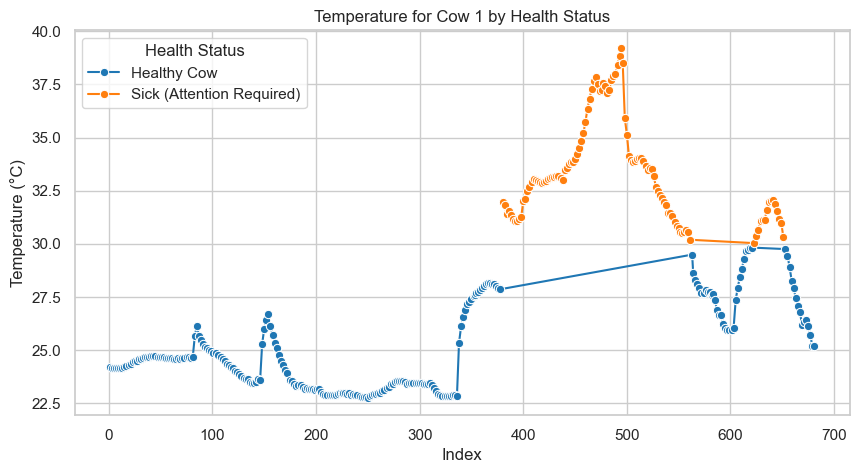

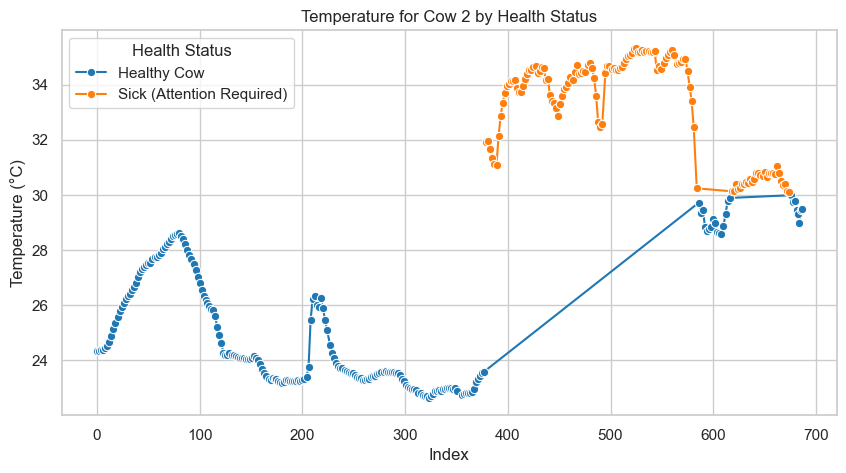

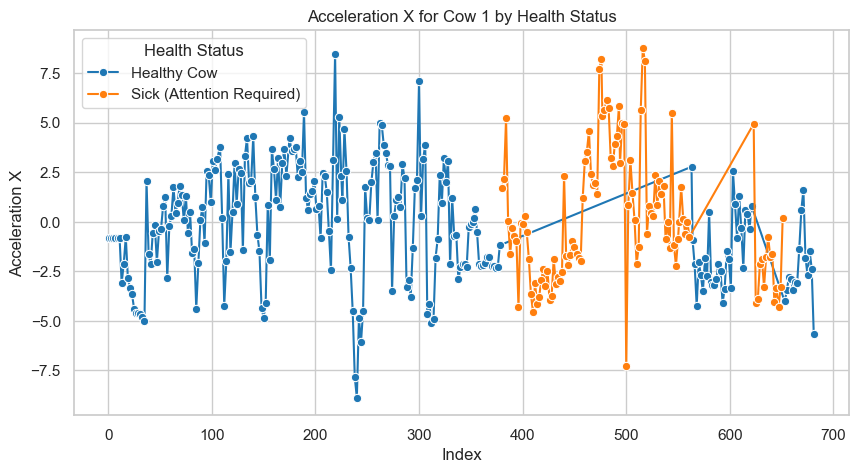

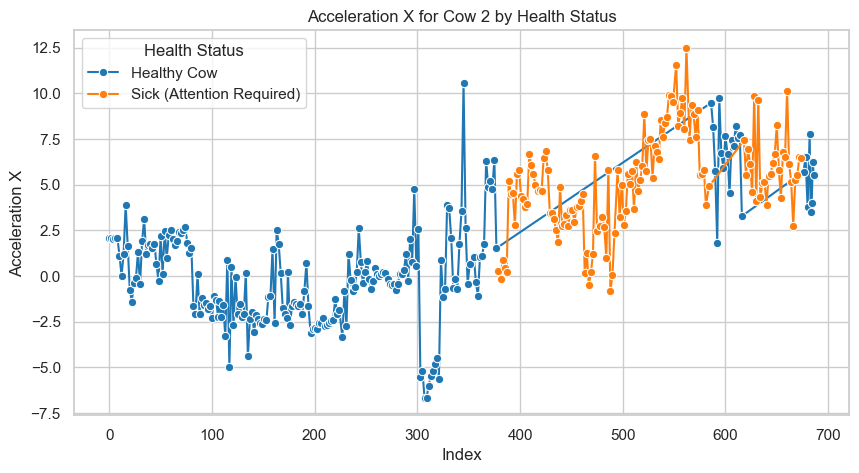

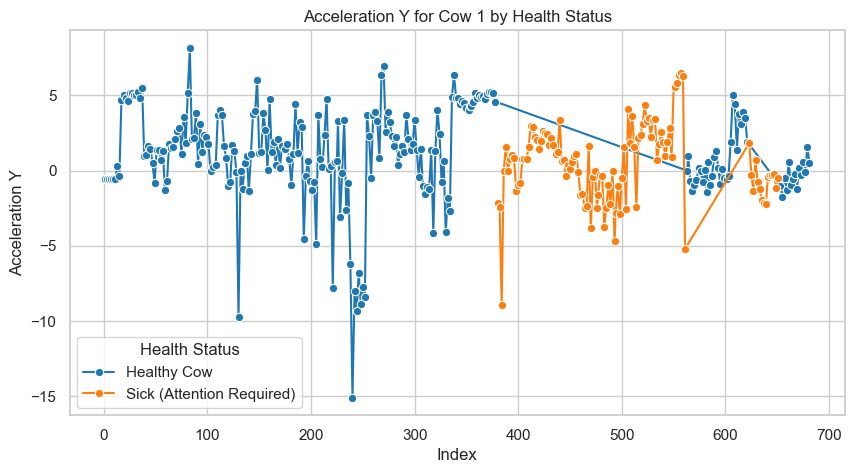

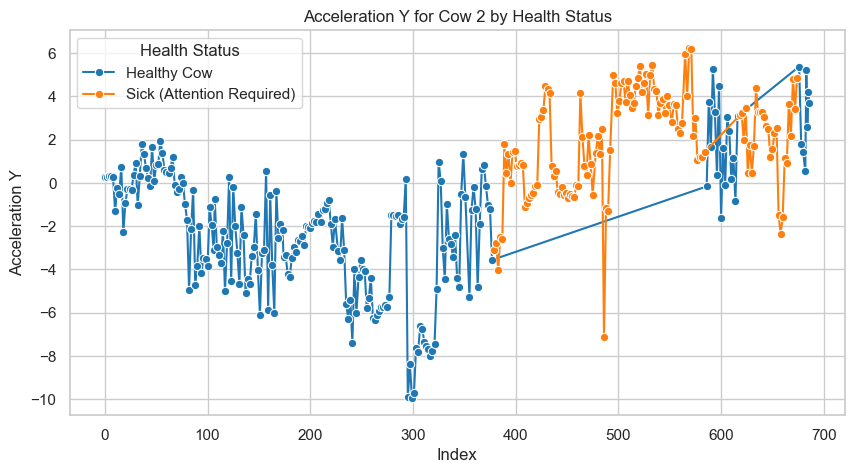

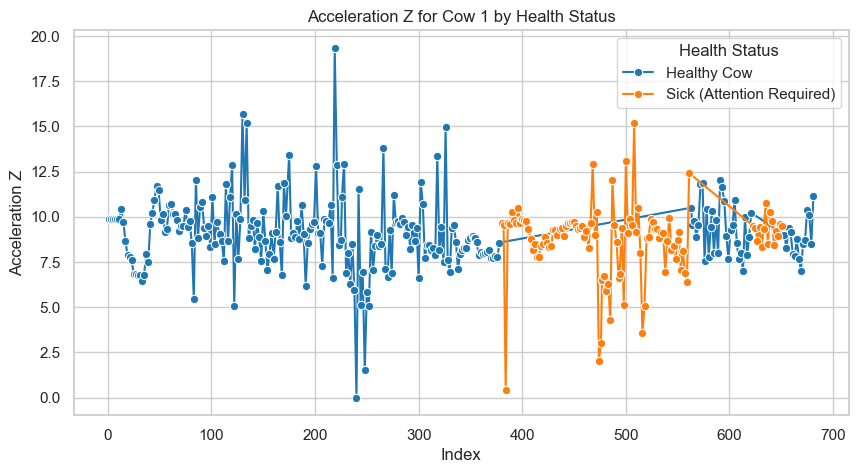

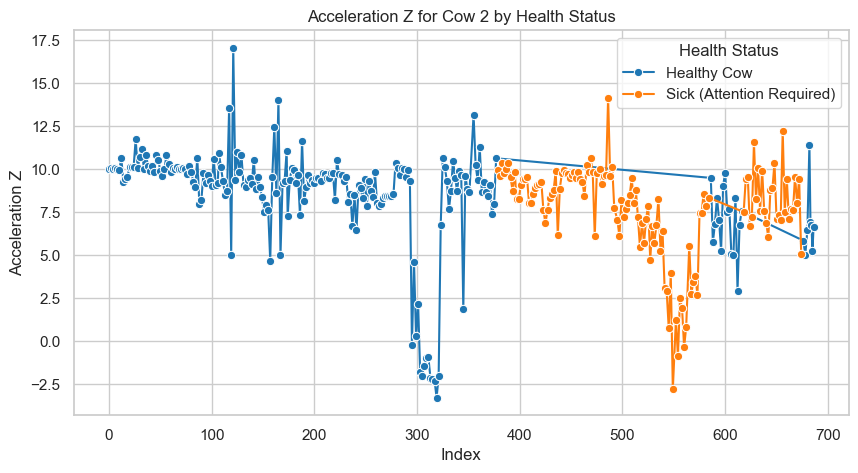

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
data = pd.read_csv(r'I:\Desktop\5.2\labeleddata4_data_file.csv')

# Filter out 'Unknown Status' from the dataset
data = data[data['HealthStatus'].isin(['Healthy Cow', 'Sick (Attention Required)'])]

# Set up the plotting style
sns.set(style="whitegrid")

# Separate the data by NodeID (Cows 1 and 2)
data_cow_1 = data[data['NodeID'] == 1]
data_cow_2 = data[data['NodeID'] == 2]

# Function to plot Activity Magnitude for each cow and compare health
def plot_activity_magnitude(data, cow_id):
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=data, x=data.index, y='ActivityMagnitude', hue='HealthStatus', marker='o', palette='tab10')
    plt.title(f"Activity Magnitude for Cow {cow_id} by Health Status")
    plt.xlabel('Index')
    plt.ylabel('Activity Magnitude')
    plt.legend(title='Health Status')
    plt.grid(True)
    plt.show()

# Plot Activity Magnitude for Cow 1
plot_activity_magnitude(data_cow_1, cow_id=1)

# Plot Activity Magnitude for Cow 2
plot_activity_magnitude(data_cow_2, cow_id=2)

# Function to plot other parameters for comparison between cows
def plot_parameter(data, parameter, title, ylabel, cow_id):
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=data, x=data.index, y=parameter, hue='HealthStatus', marker='o', palette='tab10')
    plt.title(f"{title} for Cow {cow_id} by Health Status")
    plt.xlabel('Index')
    plt.ylabel(ylabel)
    plt.legend(title='Health Status')
    plt.grid(True)
    plt.show()

# Plot Temperature for Cow 1
plot_parameter(data_cow_1, 'Temperature', 'Temperature', 'Temperature (°C)', cow_id=1)

# Plot Temperature for Cow 2
plot_parameter(data_cow_2, 'Temperature', 'Temperature', 'Temperature (°C)', cow_id=2)

# Plot Acceleration X for Cow 1
plot_parameter(data_cow_1, 'AcclX', 'Acceleration X', 'Acceleration X', cow_id=1)

# Plot Acceleration X for Cow 2
plot_parameter(data_cow_2, 'AcclX', 'Acceleration X', 'Acceleration X', cow_id=2)

# Plot Acceleration Y for Cow 1
plot_parameter(data_cow_1, 'AcclY', 'Acceleration Y', 'Acceleration Y', cow_id=1)

# Plot Acceleration Y for Cow 2
plot_parameter(data_cow_2, 'AcclY', 'Acceleration Y', 'Acceleration Y', cow_id=2)

# Plot Acceleration Z for Cow 1
plot_parameter(data_cow_1, 'AcclZ', 'Acceleration Z', 'Acceleration Z', cow_id=1)

# Plot Acceleration Z for Cow 2
plot_parameter(data_cow_2, 'AcclZ', 'Acceleration Z', 'Acceleration Z', cow_id=2)


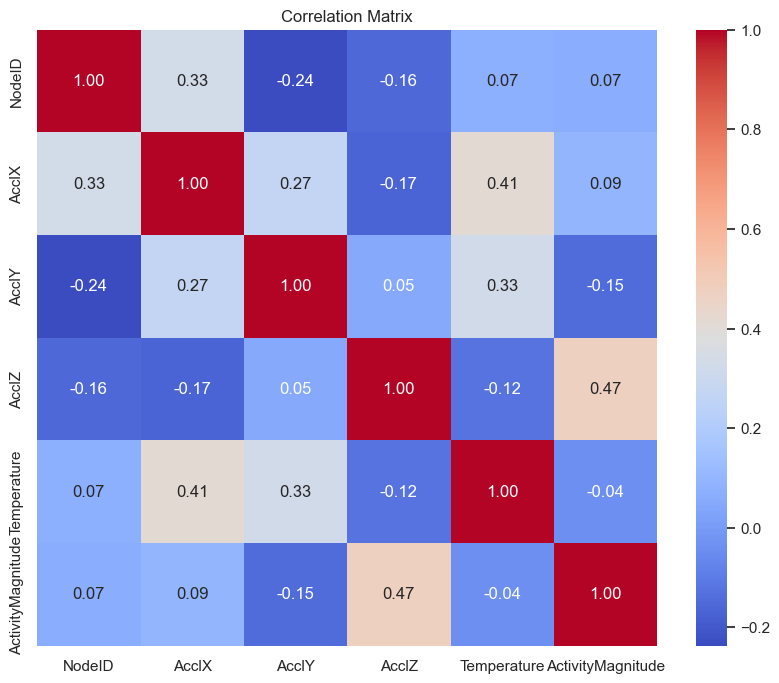

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your data
data = pd.read_csv(r'I:\Desktop\5.2\labeleddata4_data_file.csv')

# Filter out 'Unknown Status' from the dataset
data = data[data['HealthStatus'].isin(['Healthy Cow', 'Sick (Attention Required)'])]

# Select only numeric columns for correlation matrix
numeric_data = data.select_dtypes(include=[float, int])

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()


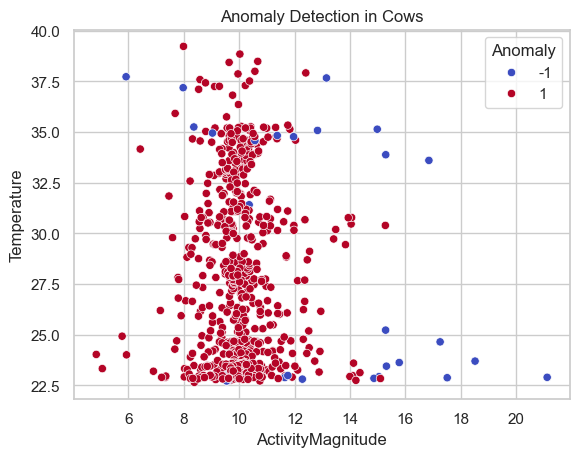

In [8]:
from sklearn.ensemble import IsolationForest

# Apply Isolation Forest for anomaly detection
model = IsolationForest(contamination=0.05, random_state=42)
data['Anomaly'] = model.fit_predict(data[['ActivityMagnitude', 'Temperature', 'AcclX', 'AcclY', 'AcclZ']])

# Visualize anomalies
sns.scatterplot(data=data, x='ActivityMagnitude', y='Temperature', hue='Anomaly', palette='coolwarm')
plt.title("Anomaly Detection in Cows")
plt.show()


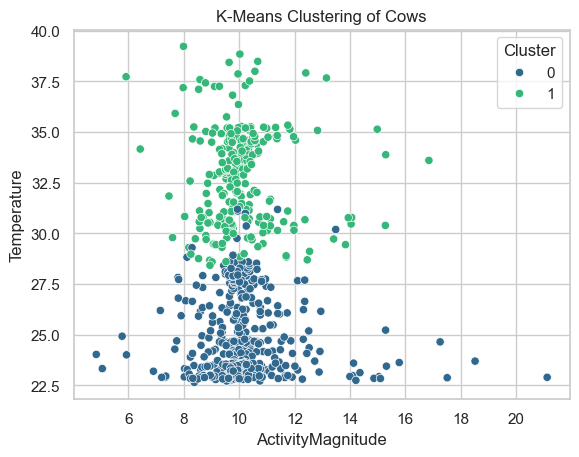

In [9]:
from sklearn.cluster import KMeans

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
data['Cluster'] = kmeans.fit_predict(data[['ActivityMagnitude', 'Temperature', 'AcclX', 'AcclY', 'AcclZ']])

sns.scatterplot(data=data, x='ActivityMagnitude', y='Temperature', hue='Cluster', palette='viridis')
plt.title("K-Means Clustering of Cows")
plt.show()
